# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [x] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames
- [ ] Cutoffs
    - https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c
    - Find Lower/Upper Bounds which maximises competition metric
    - Manual Logic for Final ( led to 0.5 )
- [ ] May be try several CVs
- [ ] May be play with uplift to lessen features input
    

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

import joblib
import os
import shutil
import itertools

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
mining_columns: list = [i for i in dataset_df.columns if i not in ["Id","Class"]]

def compute_basic_stats(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    
    out: dict = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

# Train
basic_stats_1 = compute_basic_stats(columns=mining_columns, df=dataset_df)

basic_stats_1.to_pickle('/kaggle/working/basic_stats_1.pickle')

# Inference
# basic_stats_1 = pd.read_pickle('/kaggle/working/basic_stats_1.pickle')

  0%|          | 0/56 [00:00<?, ?it/s]

In [7]:
basic_stats_1

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [8]:
WoE_Columns = ['DU', 'BC', 'AF', 'EH', 'AM', 'FD', 'DI', 'FR', 'AB', 'CF', 'BZ', 'FE', 'AX', 'BR',
               'GB', 'AY', 'FC', 'FS', 'CC', 'GH', 'DV', 'DY', 'EE', 'GE', 'AH', 'DN', 'EP', 'EU',
               'EG', 'FI', 'DH', 'GF', 'GI', 'DE', 'DA', 'CW', 'CU', 'AZ', 'CL', 'CH', 'BD', 'BN',
               'DL', 'CS', 'FL', 'GL', 'CB', 'DF', 'BP', 'EB', 'AR', 'CD', 'EL', 'CR', 'BQ']

In [9]:
def preprocess_train(train: pd.DataFrame, numeric_features: list, save_path: str) -> None:
    woes = dict()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train[i], y=train['Class'])
        woes[i] = tmp_woe
    
    # Save WoE
    _ = joblib.dump(value=woes, filename=save_path)
    print('Saved features: ', save_path)
    
    return None

def preprocess_inference(train: pd.DataFrame, test: pd.DataFrame, 
                         numeric_features: list,
                         stats: pd.DataFrame, save_path: str) -> (pd.DataFrame, pd.DataFrame, list):
    info = dict()
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    woes = joblib.load(save_path)
    
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        train_out[i + '_WoE'] = woes[i].transform(X=train_out[i])
        test_out[i + '_WoE'] = woes[i].transform(X=test_out[i])
        out_features.append(i + '_WoE')
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features


# Only for Train
_ = preprocess_train(train=dataset_df, numeric_features=WoE_Columns, save_path='/kaggle/working/WoE.pickle')

# For Train & Inference
train_out,test_out,features = preprocess_inference(train=dataset_df, 
                                                   test=dataset_test_df,
                                                   stats=basic_stats_1, 
                                                   numeric_features=WoE_Columns,
                                                   save_path='/kaggle/working/WoE.pickle')

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Saved features:  /kaggle/working/WoE.pickle


WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

# RandomForestModel

In [33]:
class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

class TFDF_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = tfdf.keras.RandomForestModel, label = "Class", predict_func = np.mean):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        self.predict_func = predict_func
        self.cut_off_lower: float = 0.5
        self.cut_off_upper: float = 0.5
        self.cut_off: float = 0.5
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(), model_compile_kwargs = dict()):

        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X['Class'])):
                print('##### Fold',i+1)

                # Fetch values corresponding to the index 
                train_df = X.iloc[train_index]
                valid_df = X.iloc[valid_index]
                valid_ids = valid_df.index.values
                train_ids = train_df.index.values

                # Select only feature columns for training.
                train_df = train_df[self.features+[self.label]]
                valid_df = valid_df[self.features+[self.label]]

                # We need to convert the datatset from Pandas format (pd.DataFrame)
                train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=self.label)
                valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=self.label)

                # Define & Train the model and metrics
                model = self.model_obj(**model_kwargs)
                model.compile(**model_compile_kwargs) 
                model.fit(x=train_tf, class_weight=class_weight)

                # Store the model
                self.models[i] = model

                # Predict Values
                self.X_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
                self.X_summary.loc[valid_ids, i] = model.predict(x=valid_tf).flatten()
                self.valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()

                # Evaluate and store the metrics in respective dicts
                evaluation = model.evaluate(x=train_tf,return_dict=True)
                train_metric = evaluation["balanced_log_loss"]

                evaluation = model.evaluate(x=valid_tf,return_dict=True)
                val_metric = evaluation["balanced_log_loss"]

                # Plot Results
                plot_train_logs(model)

                balanced_logloss_train[i] = train_metric
                balanced_logloss_val[i] = val_metric

                print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")

        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(self.metrics['train']).mean():.4f} std: {pd.Series(self.metrics['train']).std():.4f}")
        print(f"\nValidation mean: {pd.Series(self.metrics['val']).mean():.4f} std: {pd.Series(self.metrics['val']).std():.4f}")
        
        return self
    
    def set_cut_offs(self, lower: float, upper: float):
        
        self.cut_off_lower: float = lower
        self.cut_off_upper: float = upper

    
    def predict_proba(self, X: pd.DataFrame, use_cut_offs: bool = True) -> pd.Series:
        n_splits = len(self.models)
        X_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X[self.features]) # Technial, to conert frame to tensor for makind a predictions using tensor framework
        y_probas = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            y_probas[i] = model.predict(x=X_tf).flatten() 
        
        y_proba: pd.Series = self.predict_func(y_probas, axis=1)
            
        y_proba.name = 'y_hat'
        
        # If cut-offs accepted
        if use_cut_offs:
            # lower
            y_proba = np.where(y_proba < self.cut_off_lower, 0, y_proba)
            # upper
            y_proba = np.where(y_proba > self.cut_off_upper, 1, y_proba)
        
        return y_proba
    
    def predict(self, X: pd.DataFrame) -> pd.Series:
        
        # Simple preidctins
        y_pred = self.predict_proba(X, use_cut_offs=False)
        
        # Round by Threshold
        y_pred = np.where(y_pred < self.cut_off,0,1)
        
        return y_pred
    
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            model.save(filepath=f'{save_path}/models/{fold}')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = tf.keras.models.load_model(f'{save_path}/models/{i}',
                                              custom_objects={"BalancedLogLoss": BalancedLogLoss})
            
        return self

```python
# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# load
CV_Ensemble_1_load = TFDF_CV_Ensemble()

CV_Ensemble_1_load = CV_Ensemble_1_load.load(save_path='/kaggle/working/RF/1')


# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1_load.X_summary
valid_summary_rf_1 = CV_Ensemble_1_load.valid_summary
test_summary_rf_1 = CV_Ensemble_1_load.predict(X=test_out)
model_rf_1 = CV_Ensemble_1_load.models
metrics_rf_1 = CV_Ensemble_1_load.metrics
```

```python
# Let's try to find Cutoffs organically
train_summary_rf_1_mean = train_summary_rf_1.mean(axis=1)
train_summary_rf_1_mean.name = 'Pred'

tmp = pd.concat([train_summary_rf_1_mean, train_out['Class']], axis=1).sort_index(ascending=True)

tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
tmp['count_cumsum'] = tmp['count'].cumsum()
tmp['sum_cumsum'] = tmp['sum'].cumsum()

tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

tmp['perc_sum'] = [*range(1,101)]

tmp
```

##### Fold 1
Use /tmp/tmpuxub3zk5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.064145. Found 514 examples.
Training model...
Model trained in 0:00:00.725825
Compiling model...


[INFO 23-07-30 13:09:02.7054 UTC kernel.cc:1242] Loading model from path /tmp/tmpuxub3zk5/model/ with prefix 6ceb45cda927431a
[INFO 23-07-30 13:09:02.8200 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33286 node(s), and 113 input feature(s).
[INFO 23-07-30 13:09:02.8201 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:09:02.8202 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 372ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3276


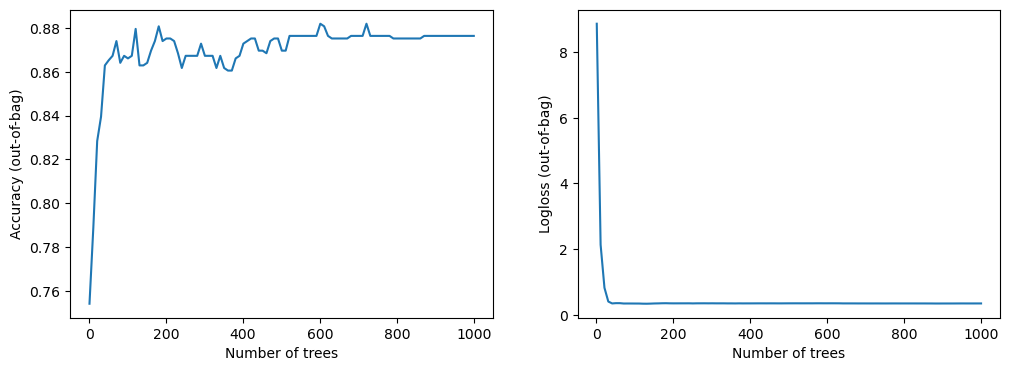


Train: 0.1731 Validation: 0.3276
##### Fold 2
Use /tmp/tmpy5grw3a6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.108013. Found 514 examples.
Training model...
Model trained in 0:00:00.729459
Compiling model...


[INFO 23-07-30 13:09:09.1872 UTC kernel.cc:1242] Loading model from path /tmp/tmpy5grw3a6/model/ with prefix d0432246e3df41f0
[INFO 23-07-30 13:09:09.3060 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33396 node(s), and 113 input feature(s).
[INFO 23-07-30 13:09:09.3062 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9515 - balanced_log_loss: 0.2998


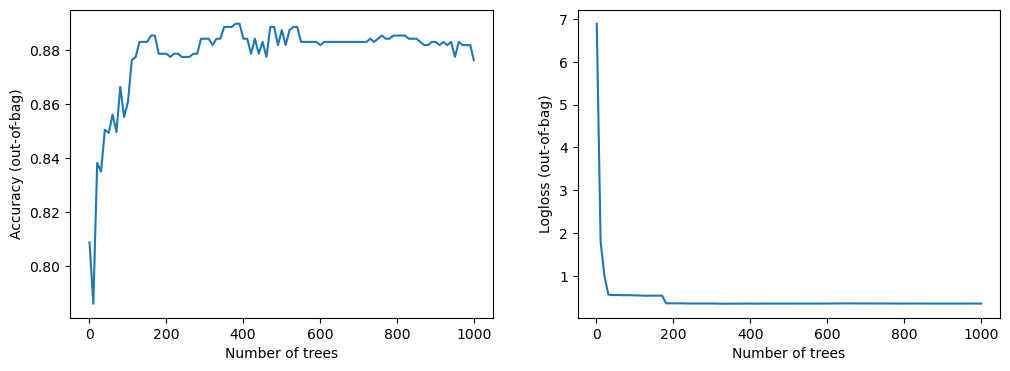


Train: 0.5067 Validation: 0.2998
##### Fold 3
Use /tmp/tmpqsqf8dgu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.096117. Found 514 examples.
Training model...
Model trained in 0:00:00.702590
Compiling model...


[INFO 23-07-30 13:09:16.4688 UTC kernel.cc:1242] Loading model from path /tmp/tmpqsqf8dgu/model/ with prefix b9702f86d9c94f5b
[INFO 23-07-30 13:09:16.5868 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33376 node(s), and 113 input feature(s).
[INFO 23-07-30 13:09:16.5869 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:09:16.5869 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 365ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3269


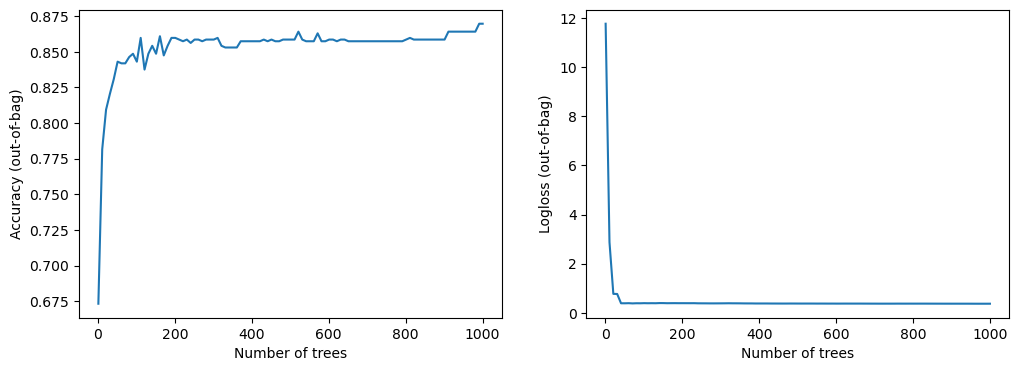


Train: 0.4829 Validation: 0.3269
##### Fold 4
Use /tmp/tmp4su2x1j6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.077852. Found 514 examples.
Training model...
Model trained in 0:00:00.753953
Compiling model...


[INFO 23-07-30 13:09:22.9677 UTC kernel.cc:1242] Loading model from path /tmp/tmp4su2x1j6/model/ with prefix 3c9c0877e4aa464a
[INFO 23-07-30 13:09:23.0832 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33208 node(s), and 113 input feature(s).
[INFO 23-07-30 13:09:23.0833 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3500


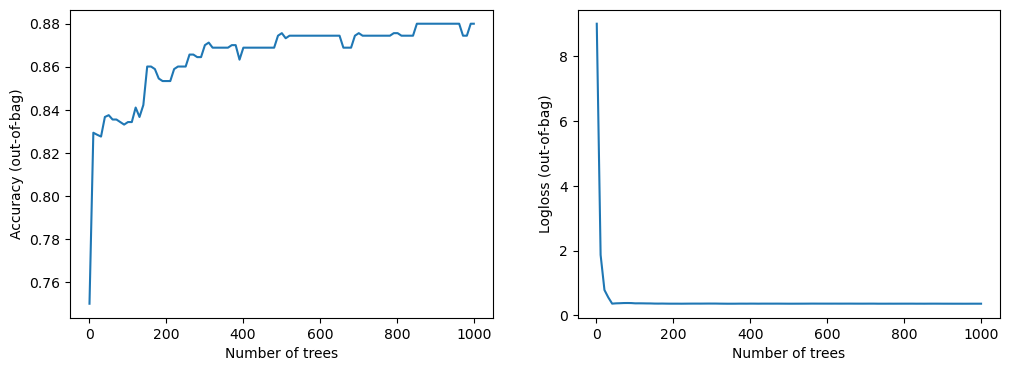


Train: 0.5023 Validation: 0.3500
##### Fold 5
Use /tmp/tmpx95h_pxm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.131111. Found 514 examples.
Training model...
Model trained in 0:00:00.713972
Compiling model...


[INFO 23-07-30 13:09:29.5544 UTC kernel.cc:1242] Loading model from path /tmp/tmpx95h_pxm/model/ with prefix 9e336f351d3b4207
[INFO 23-07-30 13:09:29.6807 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33428 node(s), and 113 input feature(s).
[INFO 23-07-30 13:09:29.6808 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:09:29.6808 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 381ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3811


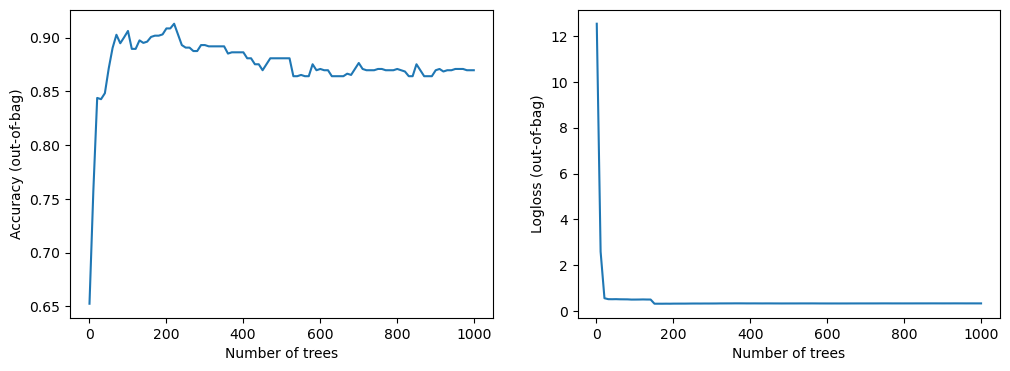


Train: 0.5224 Validation: 0.3811
##### Fold 6
Use /tmp/tmp7vo7jid0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.149996. Found 515 examples.
Training model...
Model trained in 0:00:00.692572
Compiling model...


[INFO 23-07-30 13:09:36.1719 UTC kernel.cc:1242] Loading model from path /tmp/tmp7vo7jid0/model/ with prefix 7259ae4e24f14395
[INFO 23-07-30 13:09:36.2859 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33260 node(s), and 114 input feature(s).
[INFO 23-07-30 13:09:36.2860 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 508ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9020 - balanced_log_loss: 0.4208


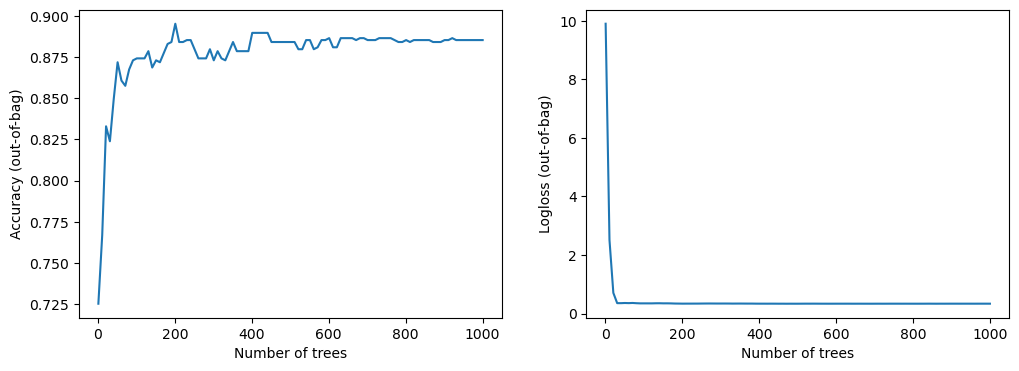


Train: 0.5493 Validation: 0.4208

Train mean: 0.4561 std: 0.1404

Validation mean: 0.3510 std: 0.0437


In [49]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_1 = CV_Ensemble_RF_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
# CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

# train_summary_rf_1 = CV_Ensemble_1.X_summary
# valid_summary_rf_1 = CV_Ensemble_1.valid_summary
# test_summary_rf_1 = CV_Ensemble_1.predict_proba(X=test_out, use_cut_offs=False)
# model_rf_1 = CV_Ensemble_1.models
# metrics_rf_1 = CV_Ensemble_1.metrics

##### Fold 1
Use /tmp/tmph2lagt4w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.471239. Found 555 examples.
Training model...
Model trained in 0:00:00.281632
Compiling model...


[INFO 23-07-30 13:09:45.8016 UTC kernel.cc:1242] Loading model from path /tmp/tmph2lagt4w/model/ with prefix b584ed5fb34e4f9c
[INFO 23-07-30 13:09:45.8442 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10268 node(s), and 112 input feature(s).
[INFO 23-07-30 13:09:45.8443 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:09:45.8443 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 399ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3026


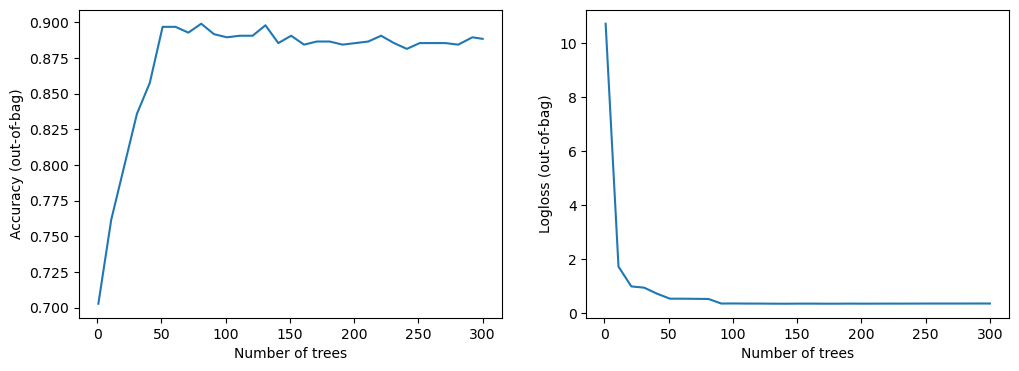


Train: 0.1776 Validation: 0.3026
##### Fold 2
Use /tmp/tmp9szrs63v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.169591. Found 555 examples.
Training model...
Model trained in 0:00:00.244437
Compiling model...


[INFO 23-07-30 13:09:52.1465 UTC kernel.cc:1242] Loading model from path /tmp/tmp9szrs63v/model/ with prefix 9242deba1ebd4a23
[INFO 23-07-30 13:09:52.1843 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10250 node(s), and 110 input feature(s).
[INFO 23-07-30 13:09:52.1844 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3518


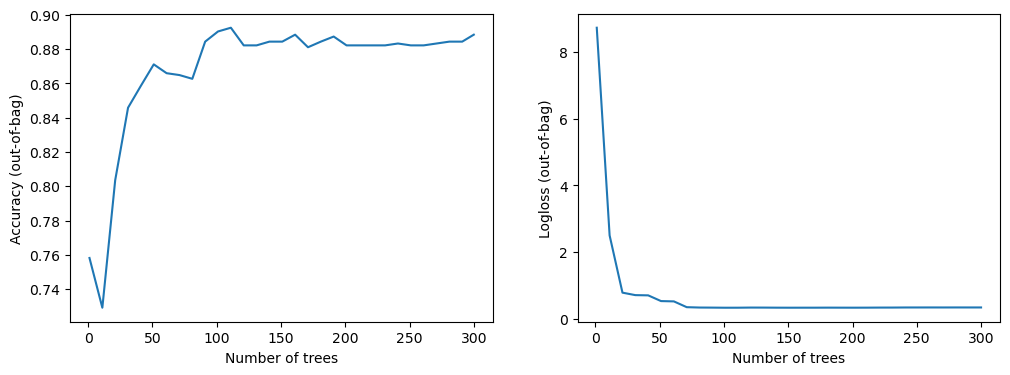


Train: 0.4775 Validation: 0.3518
##### Fold 3
Use /tmp/tmp9rquyzqi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.138200. Found 555 examples.
Training model...
Model trained in 0:00:00.232515
Compiling model...


[INFO 23-07-30 13:09:59.4104 UTC kernel.cc:1242] Loading model from path /tmp/tmp9rquyzqi/model/ with prefix c9757a51357f4815
[INFO 23-07-30 13:09:59.4468 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10302 node(s), and 113 input feature(s).
[INFO 23-07-30 13:09:59.4468 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:09:59.4469 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 373ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2532


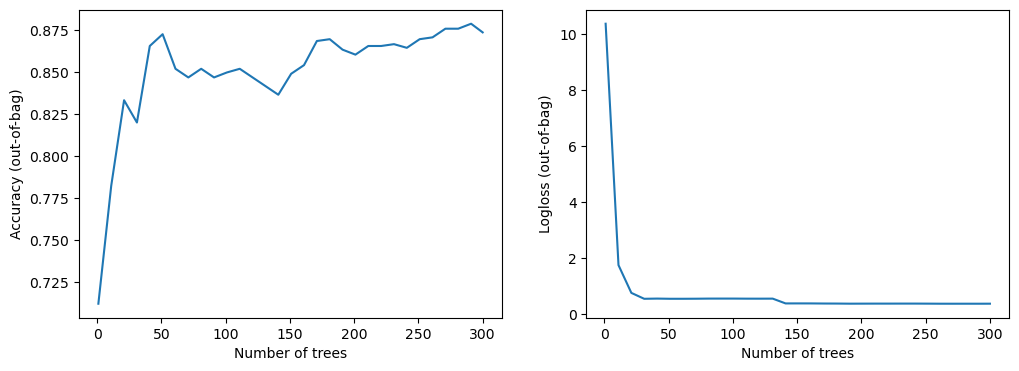


Train: 0.5394 Validation: 0.2532
##### Fold 4
Use /tmp/tmpay5az27o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.117350. Found 555 examples.
Training model...
Model trained in 0:00:00.234887
Compiling model...


[INFO 23-07-30 13:10:05.4541 UTC kernel.cc:1242] Loading model from path /tmp/tmpay5az27o/model/ with prefix c2cf4114b46d46a2
[INFO 23-07-30 13:10:05.4906 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10350 node(s), and 112 input feature(s).
[INFO 23-07-30 13:10:05.4907 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 367ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3232


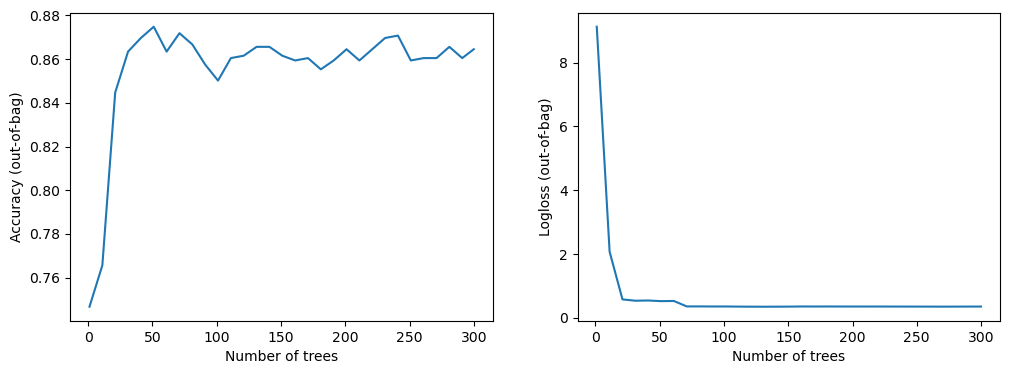


Train: 0.4308 Validation: 0.3232
##### Fold 5
Use /tmp/tmpduryy4sf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.059033. Found 555 examples.
Training model...
Model trained in 0:00:00.242237
Compiling model...


[INFO 23-07-30 13:10:11.4026 UTC kernel.cc:1242] Loading model from path /tmp/tmpduryy4sf/model/ with prefix 7373706c8d2a4a2b
[INFO 23-07-30 13:10:11.4393 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10290 node(s), and 112 input feature(s).
[INFO 23-07-30 13:10:11.4393 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:10:11.4394 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 367ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3334


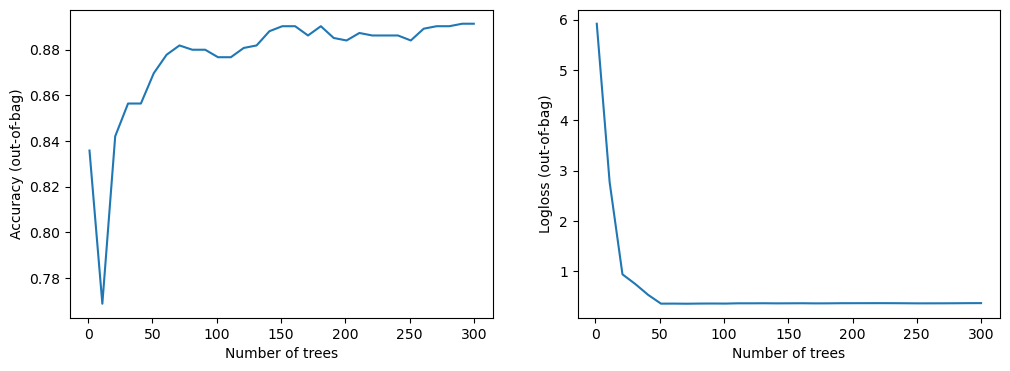


Train: 0.5062 Validation: 0.3334
##### Fold 6
Use /tmp/tmpz56nea55 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.029216. Found 555 examples.
Training model...
Model trained in 0:00:00.234921
Compiling model...


[INFO 23-07-30 13:10:18.6341 UTC kernel.cc:1242] Loading model from path /tmp/tmpz56nea55/model/ with prefix b93b94378872476f
[INFO 23-07-30 13:10:18.6709 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10464 node(s), and 113 input feature(s).
[INFO 23-07-30 13:10:18.6709 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 365ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4007


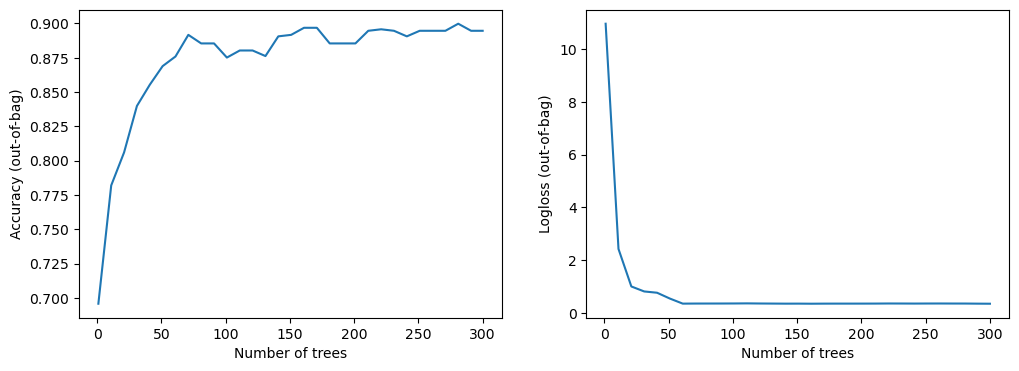


Train: 0.5031 Validation: 0.4007
##### Fold 7
Use /tmp/tmpuhevzwm2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.101479. Found 555 examples.
Training model...
Model trained in 0:00:00.236393
Compiling model...


[INFO 23-07-30 13:10:24.6562 UTC kernel.cc:1242] Loading model from path /tmp/tmpuhevzwm2/model/ with prefix 93ab1b3881c94263
[INFO 23-07-30 13:10:24.6919 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10096 node(s), and 113 input feature(s).
[INFO 23-07-30 13:10:24.6919 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:10:24.6920 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 381ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3264


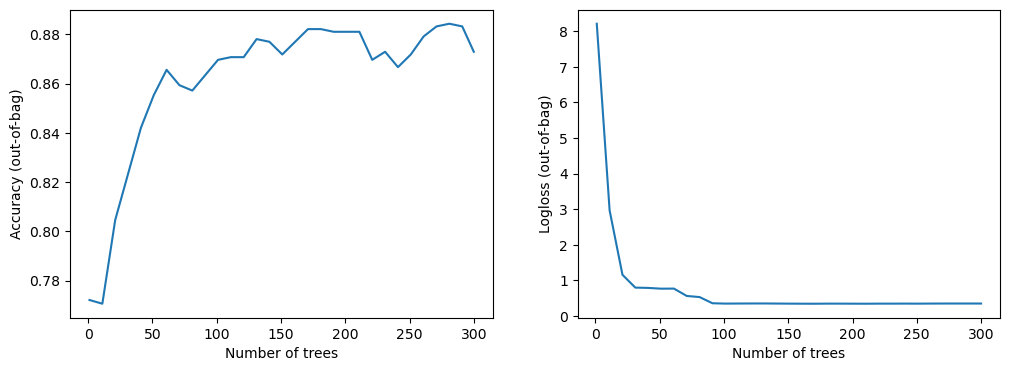


Train: 0.5776 Validation: 0.3264
##### Fold 8
Use /tmp/tmp8r500j_q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.089405. Found 556 examples.
Training model...
Model trained in 0:00:00.236671
Compiling model...


[INFO 23-07-30 13:10:30.6864 UTC kernel.cc:1242] Loading model from path /tmp/tmp8r500j_q/model/ with prefix 343df0a71a6847aa
[INFO 23-07-30 13:10:30.7245 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10276 node(s), and 113 input feature(s).
[INFO 23-07-30 13:10:30.7246 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.3201


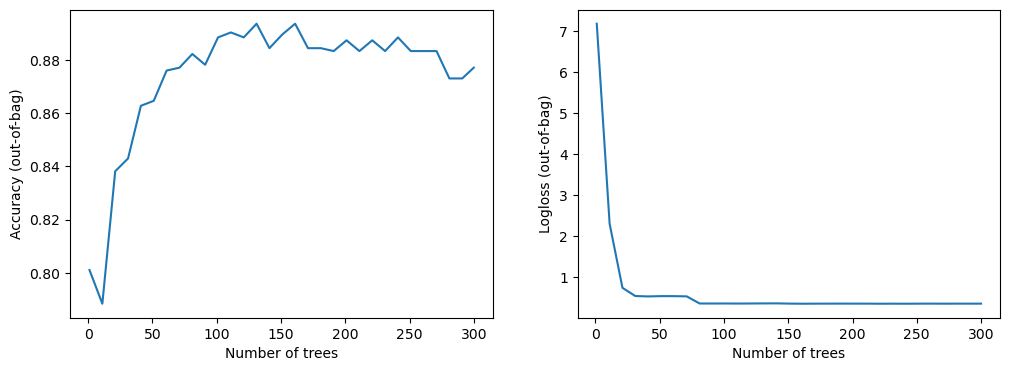


Train: 0.5045 Validation: 0.3201
##### Fold 9
Use /tmp/tmpkzthc_17 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.134550. Found 556 examples.
Training model...
Model trained in 0:00:00.233856
Compiling model...


[INFO 23-07-30 13:10:36.7453 UTC kernel.cc:1242] Loading model from path /tmp/tmpkzthc_17/model/ with prefix 95606162c69540ee
[INFO 23-07-30 13:10:36.7811 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10168 node(s), and 112 input feature(s).
[INFO 23-07-30 13:10:36.7812 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:10:36.7812 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 370ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4664


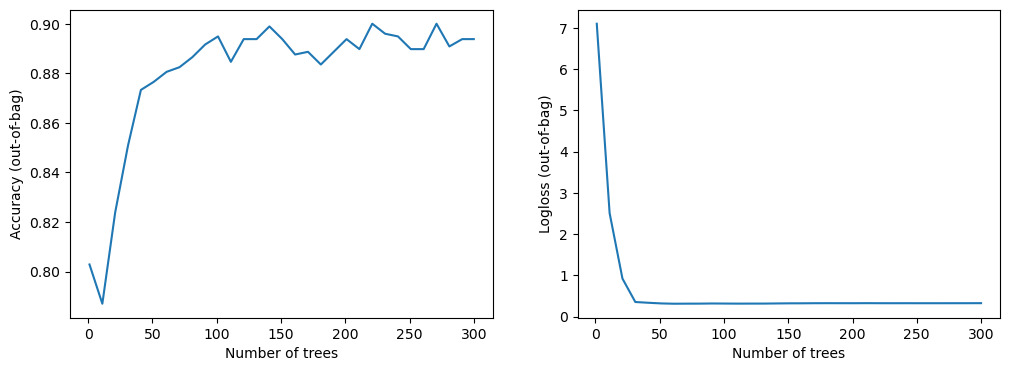


Train: 0.4883 Validation: 0.4664
##### Fold 10
Use /tmp/tmp2xzrr0so as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.099676. Found 556 examples.
Training model...
Model trained in 0:00:00.246433
Compiling model...


[INFO 23-07-30 13:10:42.7091 UTC kernel.cc:1242] Loading model from path /tmp/tmp2xzrr0so/model/ with prefix 347c678d7854434d
[INFO 23-07-30 13:10:42.7461 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10406 node(s), and 111 input feature(s).
[INFO 23-07-30 13:10:42.7463 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 395ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.3531


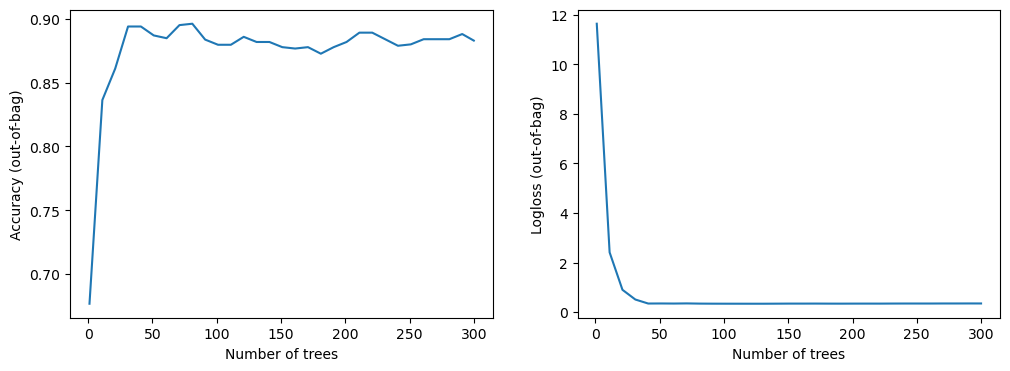


Train: 0.6396 Validation: 0.3531

Train mean: 0.4845 std: 0.1221

Validation mean: 0.3431 std: 0.0574


In [50]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_2 = CV_Ensemble_RF_2.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
# CV_Ensemble_2.save(save_path='/kaggle/working/RF/2')

# Collect attributes and predictions

# train_summary_rf_2 = CV_Ensemble_2.X_summary
# valid_summary_rf_2 = CV_Ensemble_2.valid_summary
# test_summary_rf_2 = CV_Ensemble_2.predict(X=test_out)
# model_rf_2 = CV_Ensemble_2.models
# metrics_rf_2 = CV_Ensemble_2.metrics


##### Fold 1
Use /tmp/tmpk4xow779 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.352406. Found 555 examples.
Training model...
Model trained in 0:00:00.187014
Compiling model...


[INFO 23-07-30 13:10:47.9035 UTC kernel.cc:1242] Loading model from path /tmp/tmpk4xow779/model/ with prefix bd60bf2123334c67
[INFO 23-07-30 13:10:47.9421 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11260 node(s), and 59 input feature(s).
[INFO 23-07-30 13:10:47.9421 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:10:47.9421 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3091


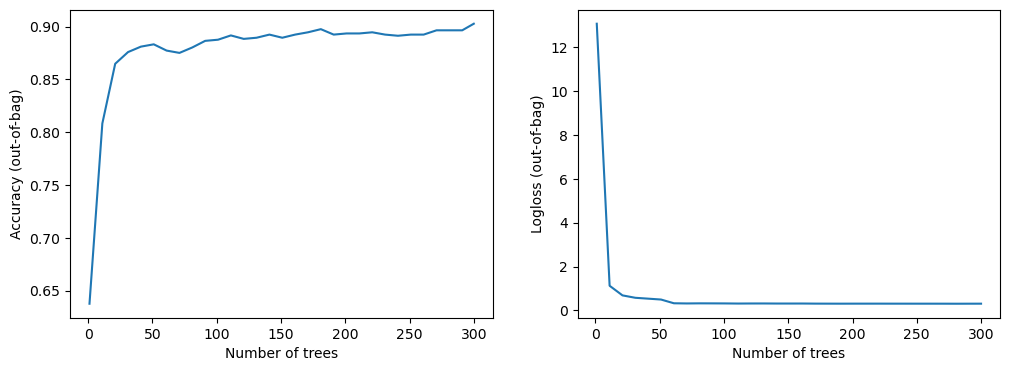


Train: 0.1883 Validation: 0.3091
##### Fold 2
Use /tmp/tmpmlvgpqqj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.220388. Found 555 examples.
Training model...
Model trained in 0:00:00.184681
Compiling model...


[INFO 23-07-30 13:10:51.7322 UTC kernel.cc:1242] Loading model from path /tmp/tmpmlvgpqqj/model/ with prefix c5b2ea75309d4707
[INFO 23-07-30 13:10:51.7701 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-30 13:10:51.7701 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3418


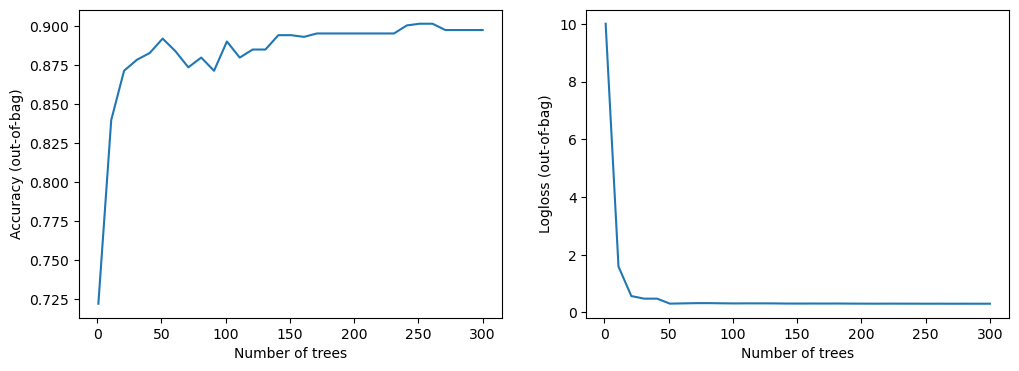


Train: 0.4968 Validation: 0.3418
##### Fold 3
Use /tmp/tmp9s_i5fzh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.291576. Found 555 examples.
Training model...
Model trained in 0:00:00.183997
Compiling model...


[INFO 23-07-30 13:10:55.6430 UTC kernel.cc:1242] Loading model from path /tmp/tmp9s_i5fzh/model/ with prefix 996778c4783149f5
[INFO 23-07-30 13:10:55.6818 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-30 13:10:55.6819 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2186


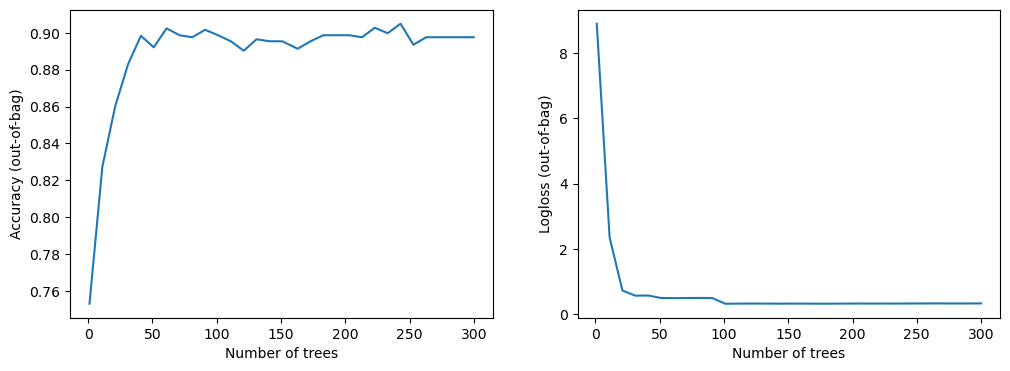


Train: 0.5382 Validation: 0.2186
##### Fold 4
Use /tmp/tmpr0p8gmvk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.250446. Found 555 examples.
Training model...
Model trained in 0:00:00.186934
Compiling model...


[INFO 23-07-30 13:10:59.5383 UTC kernel.cc:1242] Loading model from path /tmp/tmpr0p8gmvk/model/ with prefix 9cfe939298304b28
[INFO 23-07-30 13:10:59.5772 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11274 node(s), and 58 input feature(s).
[INFO 23-07-30 13:10:59.5772 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:10:59.5773 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2880


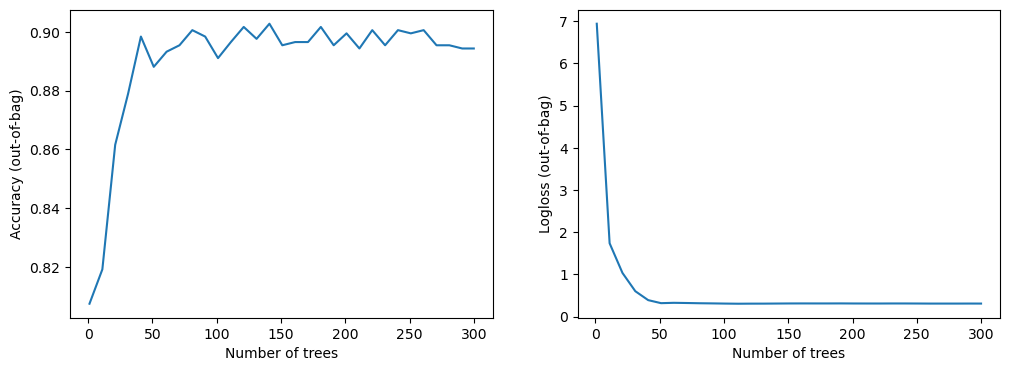


Train: 0.4091 Validation: 0.2880
##### Fold 5
Use /tmp/tmpij5pqd7a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.273194. Found 555 examples.
Training model...
Model trained in 0:00:00.193817
Compiling model...


[INFO 23-07-30 13:11:03.4683 UTC kernel.cc:1242] Loading model from path /tmp/tmpij5pqd7a/model/ with prefix 9f85d2c20c9f4de1
[INFO 23-07-30 13:11:03.5077 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11210 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:03.5078 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2901


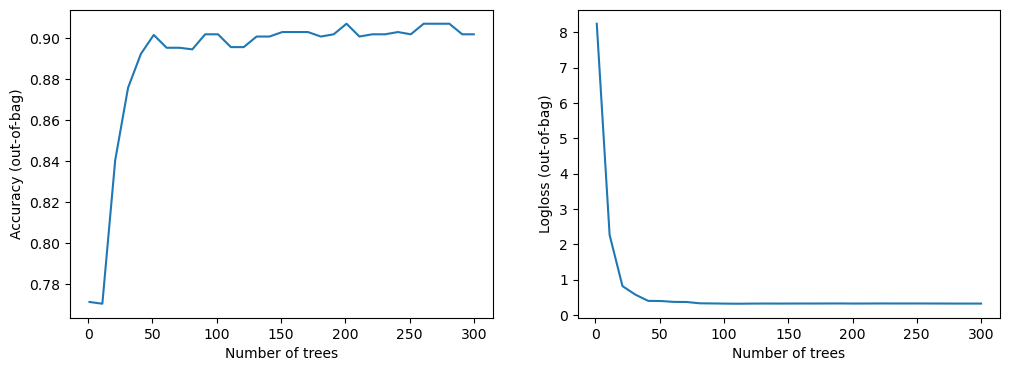


Train: 0.4847 Validation: 0.2901
##### Fold 6
Use /tmp/tmpaijd6u9f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.247898. Found 555 examples.
Training model...
Model trained in 0:00:00.180391
Compiling model...


[INFO 23-07-30 13:11:07.7879 UTC kernel.cc:1242] Loading model from path /tmp/tmpaijd6u9f/model/ with prefix 8265e95ce4af416b
[INFO 23-07-30 13:11:07.8264 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11268 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:07.8265 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3444


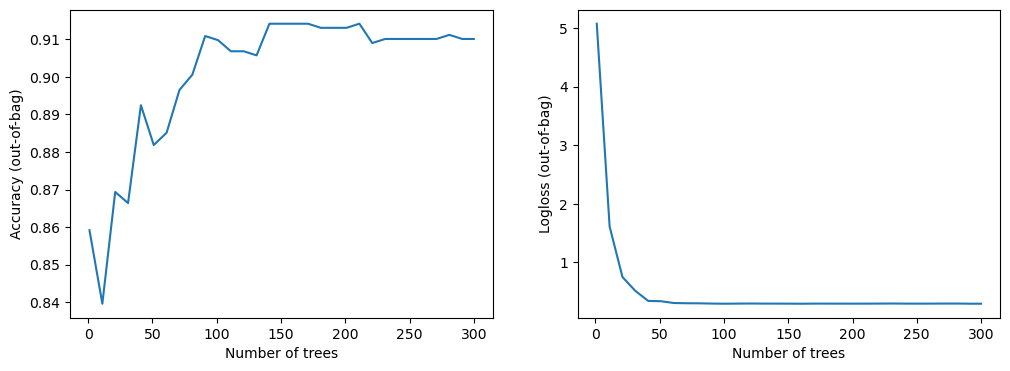


Train: 0.4697 Validation: 0.3444
##### Fold 7
Use /tmp/tmpgk6zkcqy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.269136. Found 555 examples.
Training model...
Model trained in 0:00:00.186678
Compiling model...


[INFO 23-07-30 13:11:11.6711 UTC kernel.cc:1242] Loading model from path /tmp/tmpgk6zkcqy/model/ with prefix 73e0f65e614940bd
[INFO 23-07-30 13:11:11.7092 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11172 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:11.7092 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:11:11.7092 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 258ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2836


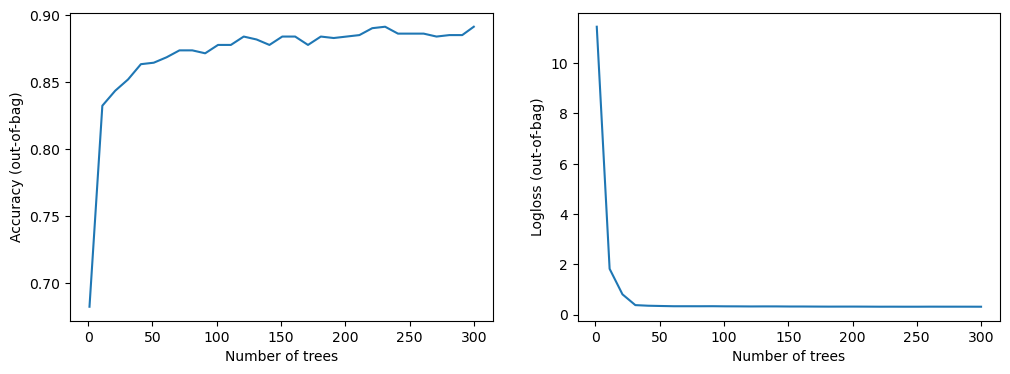


Train: 0.5343 Validation: 0.2836
##### Fold 8
Use /tmp/tmpvch3mu7q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.272796. Found 556 examples.
Training model...
Model trained in 0:00:00.182159
Compiling model...


[INFO 23-07-30 13:11:15.5133 UTC kernel.cc:1242] Loading model from path /tmp/tmpvch3mu7q/model/ with prefix c87127c221eb451b
[INFO 23-07-30 13:11:15.5510 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11026 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:15.5510 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2572


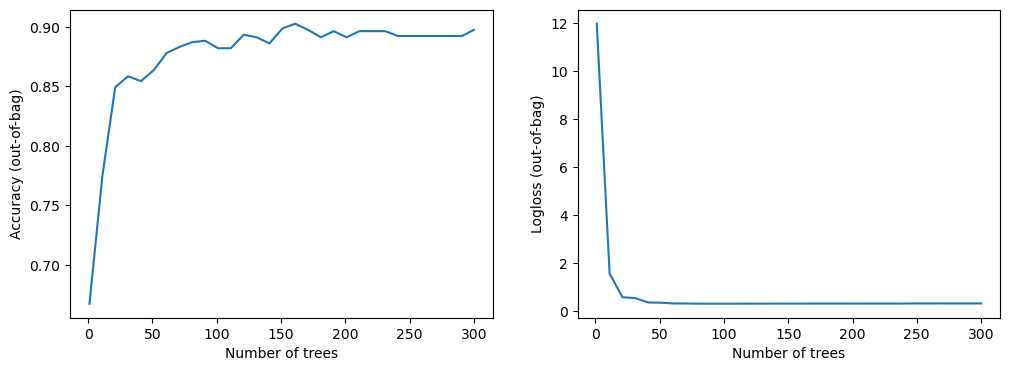


Train: 0.4778 Validation: 0.2572
##### Fold 9
Use /tmp/tmpylbybkpu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.305513. Found 556 examples.
Training model...
Model trained in 0:00:00.193648
Compiling model...


[INFO 23-07-30 13:11:19.4442 UTC kernel.cc:1242] Loading model from path /tmp/tmpylbybkpu/model/ with prefix 591513b0c1b844d9
[INFO 23-07-30 13:11:19.4824 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11098 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:19.4826 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 300ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4250


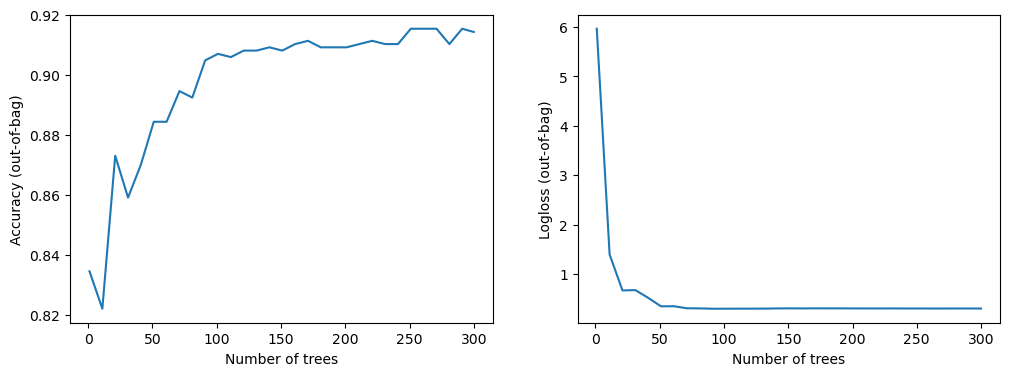


Train: 0.4395 Validation: 0.4250
##### Fold 10
Use /tmp/tmpuxnjqmdn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.326204. Found 556 examples.
Training model...
Model trained in 0:00:00.186000
Compiling model...


[INFO 23-07-30 13:11:25.9744 UTC kernel.cc:1242] Loading model from path /tmp/tmpuxnjqmdn/model/ with prefix cedc3a7bb3be4aa1
[INFO 23-07-30 13:11:26.0148 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11344 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:26.0149 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:11:26.0149 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3016


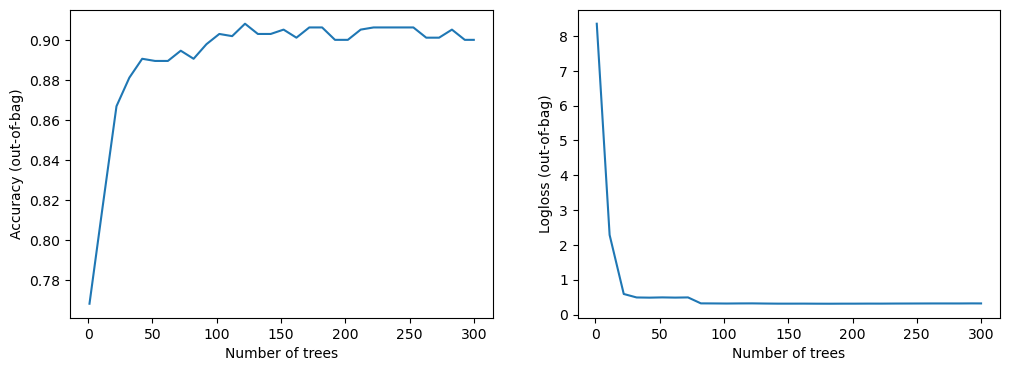


Train: 0.6154 Validation: 0.3016

Train mean: 0.4654 std: 0.1129

Validation mean: 0.3059 std: 0.0558


In [51]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_3 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_3 = CV_Ensemble_RF_3.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
# CV_Ensemble_3.save(save_path='/kaggle/working/RF/3')

# Collect attributes and predictions

# train_summary_rf_3 = CV_Ensemble_3.X_summary
# valid_summary_rf_3 = CV_Ensemble_3.valid_summary
# test_summary_rf_3 = CV_Ensemble_3.predict(X=test_out)
# model_rf_3 = CV_Ensemble_3.models
# metrics_rf_3 = CV_Ensemble_3.metrics

##### Fold 1
Use /tmp/tmp9ddan8il as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.224175. Found 308 examples.
Training model...


[INFO 23-07-30 13:11:31.8755 UTC kernel.cc:1242] Loading model from path /tmp/tmp9ddan8il/model/ with prefix 16347a782285464d


Model trained in 0:00:02.444025
Compiling model...


[INFO 23-07-30 13:11:32.4327 UTC decision_forest.cc:660] Model loaded with 20000 root(s), 139246 node(s), and 58 input feature(s).
[INFO 23-07-30 13:11:32.4328 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 309ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9191 - balanced_log_loss: 0.3833


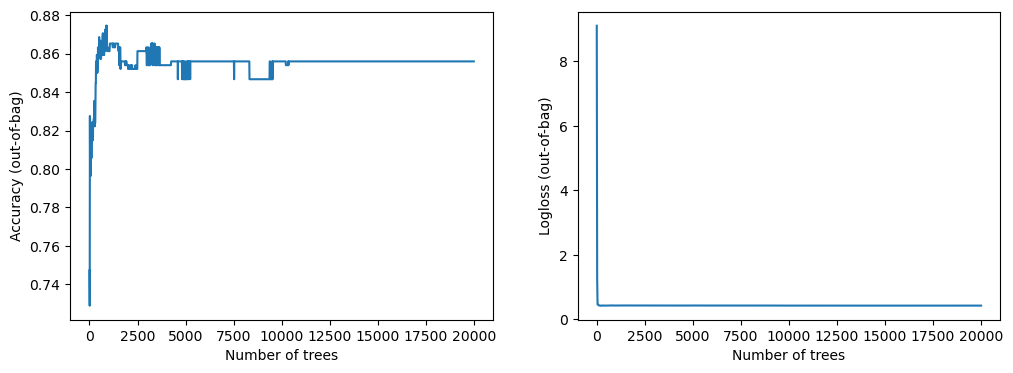


Train: 0.3452 Validation: 0.3833
##### Fold 2
Use /tmp/tmpeofmxj76 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.216970. Found 309 examples.
Training model...


[INFO 23-07-30 13:11:40.6454 UTC kernel.cc:1242] Loading model from path /tmp/tmpeofmxj76/model/ with prefix 61446285ca484142


Model trained in 0:00:02.399724
Compiling model...


[INFO 23-07-30 13:11:41.1852 UTC decision_forest.cc:660] Model loaded with 20000 root(s), 139766 node(s), and 59 input feature(s).
[INFO 23-07-30 13:11:41.1853 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-30 13:11:41.1853 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 305ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9123 - balanced_log_loss: 0.3998


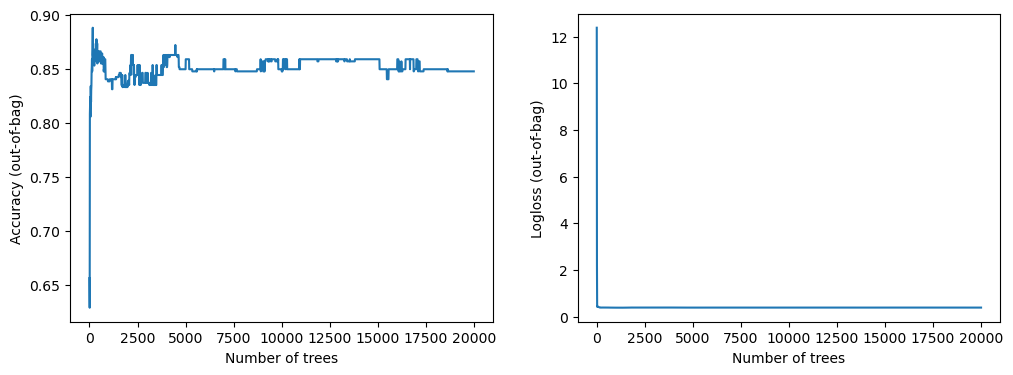


Train: 0.7033 Validation: 0.3998

Train mean: 0.5243 std: 0.2532

Validation mean: 0.3915 std: 0.0116


In [52]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_RF_4 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_RF_4 = CV_Ensemble_RF_4.fit(X=train_out, 
                                  features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=3, num_trees=20000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# GradientBoostedTreesModel

In [ ]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_1 = CV_Ensemble_GBT_1.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=5, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
# CV_Ensemble_GBT_1.save(save_path='/kaggle/working/GBT/1')

# Collect attributes and predictions

train_summary_gbt_1 = CV_Ensemble_GBT_1.X_summary
valid_summary_gbt_1 = CV_Ensemble_GBT_1.valid_summary
test_summary_gbt_1 = CV_Ensemble_GBT_1.predict(X=test_out)
model_gbt_1 = CV_Ensemble_GBT_1.models
metrics_gbt_1 = CV_Ensemble_GBT_1.metrics

In [ ]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_2 = CV_Ensemble_GBT_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=2, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
# CV_Ensemble_GBT_2.save(save_path='/kaggle/working/GBT/2')

# Collect attributes and predictions

train_summary_gbt_2 = CV_Ensemble_GBT_2.X_summary
valid_summary_gbt_2 = CV_Ensemble_GBT_2.valid_summary
test_summary_gbt_2 = CV_Ensemble_GBT_2.predict(X=test_out)
model_gbt_2 = CV_Ensemble_GBT_2.models
metrics_gbt_2 = CV_Ensemble_GBT_2.metrics

# TabPFN

In [59]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics

class TabPFN_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = TabPFNClassifier, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(N_ensemble_configurations=64)):
        
        # Case CV Ensmble
        # TODO: Case of N_ensemble_configurations
        
        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
            print('##### Fold',i)
            # Fetch values corresponding to the index 
            train_df = X.iloc[train_index]
            valid_df = X.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[self.features+[self.label]]
            valid_df = valid_df[self.features+[self.label]]

            # Define & Train the model
            model = self.model_obj(**model_kwargs)
            model.fit(train_df[self.features],train_df[self.label])

            # Store the model
            self.models[i] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[self.features])[:,1]
            p_val = model.predict_proba(valid_df[self.features])[:,1]

            # Predict Values
            self.X_summary.loc[train_ids, i] = p_train
            self.valid_summary.loc[valid_ids, 0] = p_val

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[self.label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[self.label].values,y_pred=p_val)

            balanced_logloss_train[i] = train_metric
            balanced_logloss_val[i] = val_metric

            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
        print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict_proba(X[self.features])[:,1]
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            joblib.dump(value=model, filename=f'{save_path}/models/{fold}.pickle')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = joblib.load(filename=f'{save_path}/models/{name}')
            
        return self

Before
```python
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)
```

In [ ]:
%%time
# TabPFN tabpfn_

features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_1, test_summary_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
    train=train_out,test=test_out, features=features_slice)

# os.makedirs('/kaggle/working/TabPFN/1',exist_ok=True)
# joblib.dump(value=model_tabpfn_1, filename='/kaggle/working/TabPFN/1/1.pickle')

In [ ]:
%%time
# TabPFN
features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# train
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs = dict(N_ensemble_configurations=64))

# save
# TabPFN_CV_Ensemble_2.save(save_path='/kaggle/working/TabPFN/2')

# Collect attributes and predictions

train_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.X_summary
valid_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.valid_summary
test_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.predict(X=test_out)
model_tabpfn_2 = TabPFN_CV_Ensemble_2.models
metrics_tabpfn_2 = TabPFN_CV_Ensemble_2.metrics

# for inference load

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble_2_load.load(save_path='/kaggle/working/TabPFN/2')


# train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
#     train=train_out,test=test_out, features=features_slice, n_splits=6)

# Cut-Offs

In [47]:
def compute_cut_off(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    # Let's try to find Cutoffs organically
    y_pred.name = 'Pred'
    y_true.name = 'Class'

    tmp = pd.concat([y_pred, y_true], axis=1).sort_index(ascending=True)

    tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
    tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
    tmp['count_cumsum'] = tmp['count'].cumsum()
    tmp['sum_cumsum'] = tmp['sum'].cumsum()

    tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

    tmp['perc_sum'] = [*range(1,101)]

    return tmp

## Random Forest

RF: CV_Ensemble_3

In [45]:
y_pred = CV_Ensemble_3.predict_proba(train_out, use_cut_offs=False)
y_true = train_out['Class']

1/1 [==============================] - 0s 195ms/step


In [48]:
compute_cut_off(y_pred=y_pred, y_true=y_true)

,sum,count,count_cumsum,sum_cumsum,bads_rate,perc_sum
Pred_Bins,,,,,,
"(-0.0006670000000000001, 0.00305]",0,7,7,0,0.000000,1
"(0.00305, 0.005]",0,7,14,0,0.000000,2
"(0.005, 0.00649]",0,5,19,0,0.000000,3
"(0.00649, 0.00767]",0,6,25,0,0.000000,4
"(0.00767, 0.00987]",0,6,31,0,0.000000,5
"(0.00987, 0.0113]",0,6,37,0,0.000000,6
"(0.0113, 0.013]",0,7,44,0,0.000000,7
"(0.013, 0.0147]",0,7,51,0,0.000000,8
"(0.0147, 0.0171]",0,5,56,0,0.000000,9


In [53]:
CV_Ensemble_RF_3.set_cut_offs(lower=0.11,upper=0.892) # 95 perc 0.892 and 52% 0.11

In [56]:
print(CV_Ensemble_RF_3.cut_off_lower)
print(CV_Ensemble_RF_3.cut_off_upper)

0.11
0.892


In [63]:
y_pred_rf_train = CV_Ensemble_3.predict_proba(train_out, use_cut_offs=True)

1/1 [==============================] - 0s 195ms/step


In [67]:
y_pred_rf_train

617

In [65]:
print('Before')
print(balanced_logloss_np(y_pred=y_pred.values,y_true=y_true.values))
print('After')
print(balanced_logloss_np(y_pred=y_pred_rf_train,y_true=y_true.values))

Before
0.19900611473895546
After
1.923862215458414


# Ensemble CV

Idea to create Entity that can accept multiple previously fitted Regressors and then create final estimate.

In [ ]:
class Diff_Class_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, label = "Class"):
        self.label: str = label
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list() # Shall be Union of all features
        self.models: dict = dict() # Each Feature is a scikit-learn compatible & fitted
        self.metrics: dict = dict()
        self.weights: np.ndarray = None
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, 
            models: list, weights: np.ndarray, # List of Estimated Regressors 
            splitter = StratifiedKFold()):
        
        # Count how many sub models we have 
        n_models = len(models)
        self.models = dict()
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan), index=X.index) # For In-Sample Predictions of each Fold
     
        # Make Estimations
        for i,model in enumerate(models):
            X_predicted: pd.DataFrame = model.predict(X) # Shall have original features, which would be checked in DF X
            X_predicted: pd.Series = X_predicted.mean(axis=1)
            self.X_summary[i] = X_predicted
            self.models[i] = model
            self.features = self.features + model.features
        
        # To omit duplications
        self.features: list = list(set(self.features))
        
        # Compute Metrics for each weight combinations
        self.metrics = {}
        for weight in weights:
            #weight = weight.reshape(2,1)
            weight_hash = tuple(weight) #.tolist()
            weight_1D = weight.reshape(-1,1)
            
            self.metrics[weight_hash] = dict(train=list(),valid=list())
            
            for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
                # Fetch values corresponding to the index 
                train_df: np.ndarray = self.X_summary.iloc[train_index].values
                valid_df: np.ndarray = self.X_summary.iloc[valid_index].values

                # Predict value for validation/Submition data
                p_train = train_df.dot(weight_1D)
                p_val = valid_df.dot(weight_1D)

                y_train_true: pd.Series = X.iloc[train_index][self.label].values
                y_valid_true: pd.Series = X.iloc[valid_index][self.label].values

                # Evaluate and store the metrics in respective dicts
                train_metric = balanced_logloss_np(y_true=y_train_true,y_pred=p_train)
                val_metric = balanced_logloss_np(y_true=y_valid_true,y_pred=p_val)

                self.metrics[weight_hash]['train'].append(train_metric)
                self.metrics[weight_hash]['valid'].append(val_metric)
            
            self.metrics[weight_hash]['train_mean'] = np.mean(self.metrics[weight_hash]['train'])
            self.metrics[weight_hash]['train_std'] = np.std(self.metrics[weight_hash]['train'])
            self.metrics[weight_hash]['valid_mean'] = np.mean(self.metrics[weight_hash]['valid'])
            self.metrics[weight_hash]['valid_std'] = np.std(self.metrics[weight_hash]['valid'])
            
        # TODO: Some Logic
        self.weights: np.ndarray = weights[0,:].reshape(-1,1)
            
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_models = len(self.models)
        Y_Preds = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan),
                               index=X.index)

        for i, model in enumerate(self.models.values()):
            Y_Preds[i] = model.predict(X).mean(axis=1)
            
        Y_Preds: np.ndarray = Y_Preds.values
        
        y_pred = Y_Preds.dot(self.weights)
        
        return y_pred

# Initialise

Diff_Class_Ensemble_3Class = Diff_Class_Ensemble(label='Class')

# Fit 
my_splitter = StratifiedKFold(n_splits=3,shuffle=True, random_state=1902)

# Weights
my_weights = list(itertools.permutations(iterable=np.linspace(0., 1., 21), r=3))
my_weights = [i for i in my_weights if round(sum(i),4) == 1]
my_weights = [i for i in my_weights if round(min(i),4) >= .15]

my_weights = np.array(my_weights)


Diff_Class_Ensemble_3Class = Diff_Class_Ensemble_3Class.fit(X=train_out,
                                                            models = [CV_Ensemble_GBT_2, 
                                                                      CV_Ensemble_3,
                                                                     TabPFN_CV_Ensemble_2], 
                                                            splitter = my_splitter,
                                                            weights = my_weights)

In [ ]:
pd.DataFrame(Diff_Class_Ensemble_3Class.metrics).T

I choose wieghts (manually):
0.35	0.15	0.50

In [ ]:
Diff_Class_Ensemble_3Class.weights

In [ ]:
Manual_Best_Weights = np.array([[0.35],[0.15],[0.50]]) # Manual_Best_Weights
Manual_Best_Weights

In [ ]:
Diff_Class_Ensemble_3Class.weights = Manual_Best_Weights

# Cut-Offs

In [ ]:
ensemble_final_train_out = Diff_Class_Ensemble_3Class.predict(X=train_out)
# ensemble_final_train_out

In [ ]:
ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)
# ensemble_final_test_out

In [ ]:
train_out['Y_Pred'] = ensemble_final_train_out

In [ ]:
def compute_cut_off(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    # Let's try to find Cutoffs organically
    y_pred.name = 'Pred'
    y_true.name = 'Class'

    tmp = pd.concat([y_pred, y_true], axis=1).sort_index(ascending=True)

    tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
    tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
    tmp['count_cumsum'] = tmp['count'].cumsum()
    tmp['sum_cumsum'] = tmp['sum'].cumsum()

    tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

    tmp['perc_sum'] = [*range(1,101)]

    return tmp

cut_off_df = compute_cut_off(y_pred=train_out['Y_Pred'], y_true=train_out['Class'])

cut_off_df

Manually I choose:
* Lower 0.205 -> to 0
* Upper 0.711 -> to 1

In [ ]:
# Lower
train_out['Y_Pred_After_CutOff'] = np.where(train_out['Y_Pred'] <= 0.205,0,train_out['Y_Pred'])

# Upper
train_out['Y_Pred_After_CutOff'] = np.where(train_out['Y_Pred'] >= 0.711,1,train_out['Y_Pred'])

In [ ]:
print('Before')
print(balanced_logloss_np(y_pred=train_out['Y_Pred'].values,y_true=train_out['Class'].values))
print('After')
print(balanced_logloss_np(y_pred=train_out['Y_Pred_After_CutOff'].values,y_true=train_out['Class'].values))

In [ ]:
test_out['Y_Pred'] = ensemble_final_test_out # ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)

# Lower
test_out['Y_Pred_After_CutOff'] = np.where(test_out['Y_Pred'] <= 0.205,0,test_out['Y_Pred'])

# Upper
test_out['Y_Pred_After_CutOff'] = np.where(test_out['Y_Pred'] >= 0.711,1,test_out['Y_Pred'])

In [ ]:
test_out

# Submission

In [ ]:
# submition_total
submition_total = test_out[['Y_Pred_After_CutOff']].copy()
submition_total['class_1'] = submition_total['Y_Pred_After_CutOff']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']].copy()
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [ ]:
submition_total.info()